# Module 3 Final Project Submission

- Student Name: John Dean
- Student Pace: Part Time
- Scheduled Review: 9/11/2020 14:00
- Instructor Name: Eli Thomas
- Blog Post URL: 

# Summary

In this project we examine the effectiveness of three models for predicting credit fraud: Logistic Regression, Support Vector Machine (SVM), and Isolation Forest. Our goal was to predict as many fraud cases as possible without generating many false positives. Our primary metric we use to judge this is our F1 score. Very little preprocessing is required as there is no missing data and most of our data has already been normalized using a PCA process.

After fitting and testing our models, we find that Logistic Regression is the best performing model, with an F1 score of .7, followed by Isolation Forest (F1 = .29), and finally our SVM model (F1 = .00). With more time and computing power, the scores of all three models could be improved greatly.

# Introduction

Since their introduction in the late 1950's, credit cards have always been subject to fraud. For the first few decades, however, the problem was generally manageable. This changed rapidly with the rise of online shopping. Traditional fraud protections such as microchips or holograms on cards have no impact when a purchase is happening online, and the amount of online transactions has increased exponentially in the last decade. 

This created a need for a more modern approach to tackling credit fraud. In 2016, more than 39 million credit card payments occurred *each day*. With such a large flood of transactions, it's imperative for creditors to take advantage of strong predictive models to reduce their liability for credit fraud. To this end, we will evaluate several different algorithms for classifying credit fraud.

We will begin with a simple logistic regression model. Following logistic regression, we will use the a Support Vector Machine-Based model (SVM), and finally we will use an Isolation Forest Anomaly detection algorithm.

# Preprocessing

### Importing Libraries and Data

In [69]:
import numpy as np
import pandas as pd
import zipfile
import sklearn
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import math
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix,roc_curve, confusion_matrix 
from sklearn.metrics import plot_roc_curve, roc_curve
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
import warnings

In [70]:
#importing our dataset and verifying a successful import
zf = zipfile.ZipFile('data.zip')
cc_df = pd.read_csv(zf.open('creditcard.csv'))
cc_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploratory Data Analysis

In [7]:
cc_df.shape

(284807, 31)

In [8]:
cc_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The features in this data set have likely been transformed using PCA dimensionality reduction in order to protect consumer identities and information, thus we have most features listed in the generic Vx form. The normalization of feature values should actually help make our algorithms more effective, so while we may lose some context, we will gain some accuracy.

In [10]:
cc_df.isna().values.any()

False

No missing values. This is great news and we can continue with our analysis. Next we will check to see how balanced our data is.

In [11]:
cc_df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [12]:
Fraud = cc_df[cc_df['Class']==1]
Valid = cc_df[cc_df['Class']==0]
state = np.random.RandomState(77)
outlier_fraction = len(Fraud)/float(len(Valid))
outlier_fraction

0.0017304750013189597

Only 492 cases of fraud out of nearly 285000 transactions! This is an extremely unbalanced data set. As we mentioned before, this will cause us problems in our first classification model, and we will discuss how to address that later. Let's move on and look for any sources of multicollinearity.

In [13]:
correlation_matrix = cc_df.corr().round(2)

<AxesSubplot:>

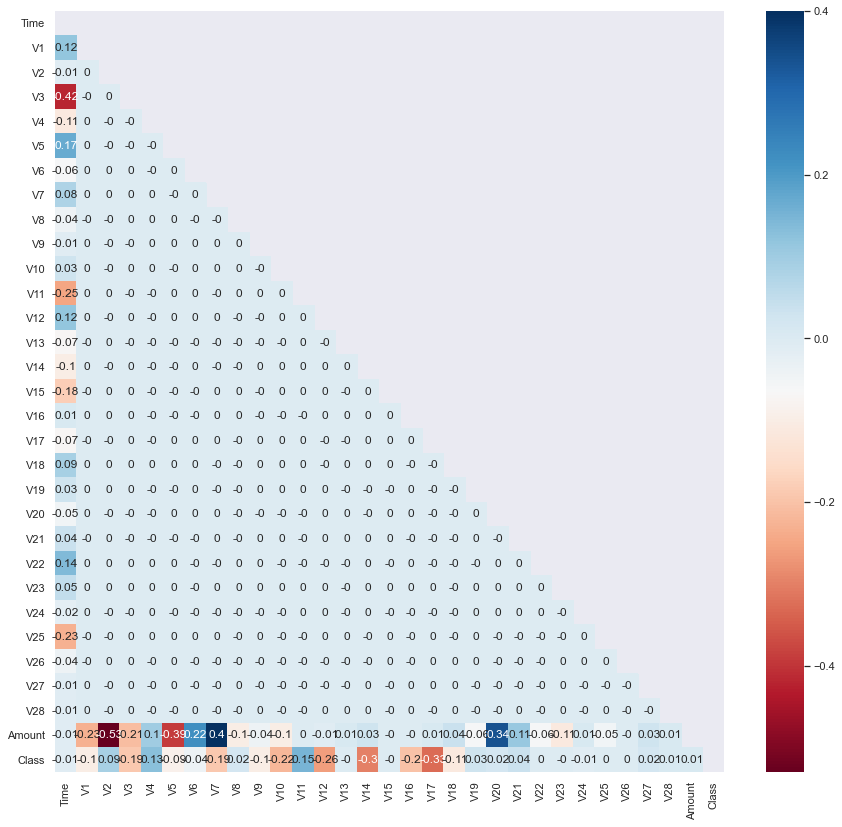

In [14]:
sns.set(rc={'figure.figsize':(15,14)})
mask = np.zeros_like(correlation_matrix,dtype=np.bool)

# Create a msk to draw only lower diagonal corr map
mask[np.triu_indices_from(mask)] = True
# use the heatmap function from seaborn to plot the correlation matrix
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, cmap='RdBu', annot=True, mask=mask)

There does not appear to be any worry about multicollinearity amongst our features. With that determined, we can feel safe moving on.

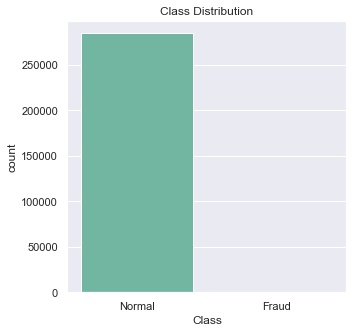

In [73]:
# Observing class imbalance
df1 = cc_df.replace({'Class': 1},{'Class':'Fraud'},regex=True)
df1 = df1.replace({'Class': 0},{'Class':'Normal'},regex=True)
plt.figure(figsize=(5,5))
ax = sns.countplot(x='Class', data= df1,palette="Set2")
plt.title('Class Distribution')
plt.show()

In [74]:
columns = list(cc_df.columns)

C:\Users\sunfl\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\sunfl\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


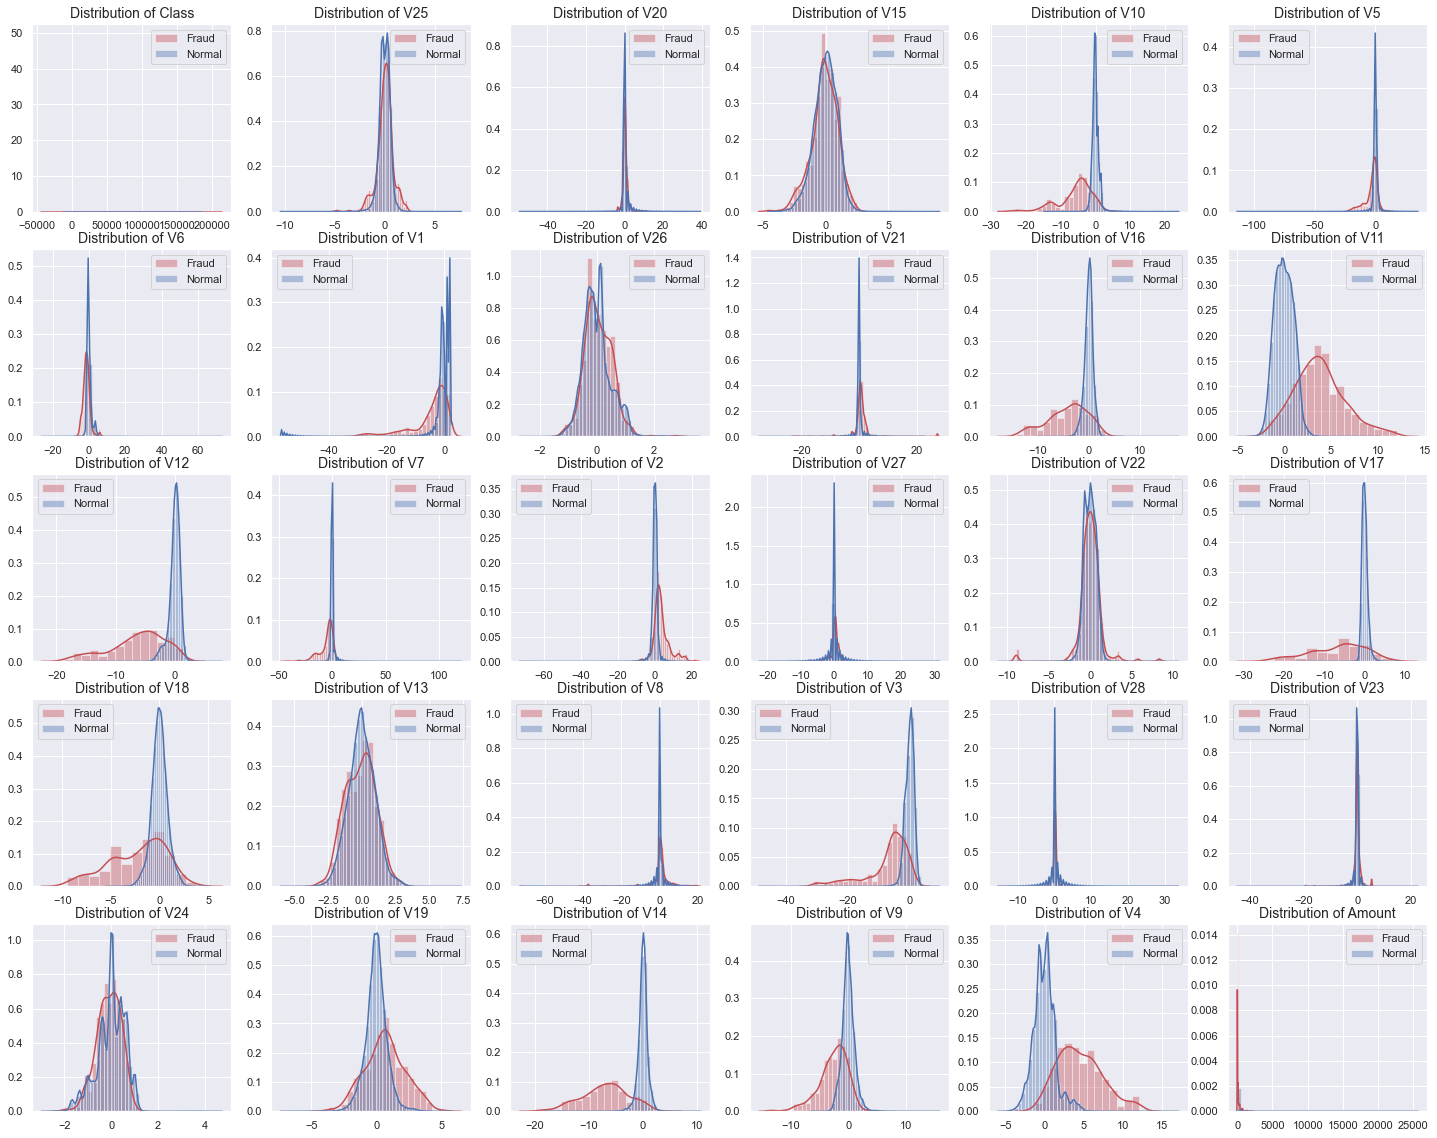

In [75]:
# Generating distribution plots for all of our features, split by class
fig, ax = plt.subplots(5, 6, figsize=(25,20))
columns = [col for col in columns if col is not 'Class']
i = 0
j = 0
for col in columns :
    k = int(i%5)
    l = int(j%6)
    sns.distplot(cc_df[col][cc_df.Class ==1], color="r", ax=ax[k][l] )
    sns.distplot(cc_df[col][cc_df.Class ==0], color="b", ax=ax[k][l])
    ax[k][l].set_title('Distribution of {}'.format(col), fontsize=14)
    ax[k][l].legend(labels=['Fraud','Normal'])
    ax[k][l].set(xlabel=None)
    i = i+1
    j = np.floor(i/1)

plt.show()

Most of our features have a fairly normal distribution. This bodes well for our modeling!It's worth noting that for several features(V10, V16, V11, V12, V17, V18, V14, and V4) the distribution of fraud cases is much different than that of the normal cases.

# Prediction Models

## Functions

In [79]:
# Function to print metrics for model performance
# Takes in 3 params; no return values
# name: a string for the model name
# y: the true y values for the set
# y_pred: the predicted y values for the set
def metric_report(name, y, y_pred):
    n_errors = (y_pred != y).sum()
    print("{} Number of Errors: {}".format(name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(y,y_pred))
    print("Classification Report :")
    print(classification_report(y,y_pred))

# Function to plot confusion matrix for the model
# Takes in 3 params; no return values
# title: a string for the model name
# y_pred: the predicted y values for the set
# y_test: the true y values for the set
def plot_conf_matrix(title, y_pred, y_test):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, cmap=plt.cm.copper, 
            xticklabels= ['Predicted Normal', 'Predicted Fraud'], 
            yticklabels=['True Normal', 'True Fraud'],
            vmin = 0,
            vmax = 100)
        plt.title("{} \n Confusion Matrix".format(title), fontsize=14)
        
# Function to plot ROC curve for the model
# Takes in 5 params; no return values
# cm: an estimator model object
# X_train: the features for the training set
# y_train: the true y values for the training set
# X_test: the features for the test set
# y_test: the true y values for the test set
def plot_roc(cm,X_train, y_train,X_test, y_test):
    fig, axes = plt.subplots(1,2, figsize = (10,5), sharey = 'row')
    plot_roc_curve(cm, X_train, y_train, ax=axes[0])
    axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[0].set_title("ROC Curve for Traning")
    
    plot_roc_curve(cm, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    axes[1].set_title("ROC Curve for Testing")
    
    plt.show() 
    
class_names = ["Normal","Fraud"]

## Logistic Regression

Our first model will be a logistic regression, which we believe will be the least effective model due to the imbalances in the data.

In [22]:
# Separating our features from our target
cc_df_x = cc_df.drop(columns=['Class'], axis = 1)
cc_df_y = cc_df['Class']

In [23]:
# Generating training and testing data
x_train, x_test, y_train, y_test = train_test_split(cc_df_x, cc_df_y, test_size = 0.25, random_state=state)

In [24]:
# Instantiating our estimator object
logreg = LogisticRegression(max_iter = 200, random_state = state, solver ='lbfgs',  n_jobs=-1)

In [25]:
# Fitting our model
logreg.fit(x_train, y_train)

LogisticRegression(max_iter=200, n_jobs=-1,
                   random_state=RandomState(MT19937) at 0x231F5837990)

In [26]:
# Generating our predictions
lr_predictions = logreg.predict(x_test)

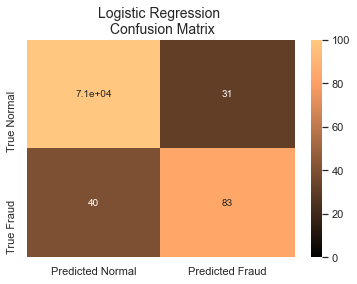

In [65]:
# Generate an plot our confusion matrix
plot_conf_matrix('Logistic Regression', lr_predictions, y_test)

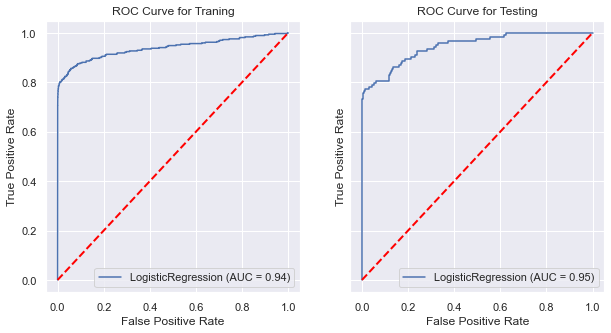

In [80]:
plot_roc(logreg, x_train, y_train, x_test, y_test)

## Support Vector Machine-based Classification

In [48]:
# Instantiating our estimator
svm_reg = OneClassSVM(gamma=0.1,nu=0.05)

In [49]:
# Fitting and predicting
svm_reg.fit(x_train)
svm_predictions = svm_reg.predict(x_test)
svm_predictions[svm_predictions == 1] = 0
svm_predictions[svm_predictions == -1] = 1

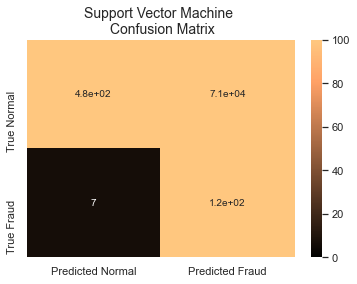

In [66]:
plot_conf_matrix('Support Vector Machine', svm_predictions, y_test)

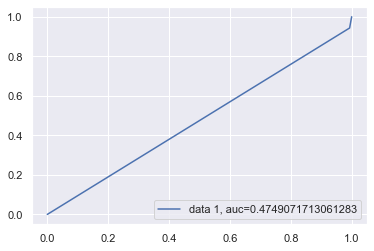

In [61]:
# Generating our ROC curve graph
fpr, tpr, _ = metrics.roc_curve(y_test,  svm_predictions)
auc = metrics.roc_auc_score(y_test, svm_predictions)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

## Isolation Forest Anomaly Detection 

In [30]:
# Instantiating our estimator model
cc_isof = IsolationForest(max_samples=len(x_train), 
                          contamination=outlier_fraction, 
                          random_state=state, 
                          n_jobs = -1)

In [31]:
# fitting and predicting
cc_isof.fit(x_train)
scores_predictions = cc_isof.decision_function(x_train)
isof_predictions = cc_isof.predict(x_test)

In [32]:
isof_predictions[isof_predictions == 1] = 0
isof_predictions[isof_predictions == -1] = 1

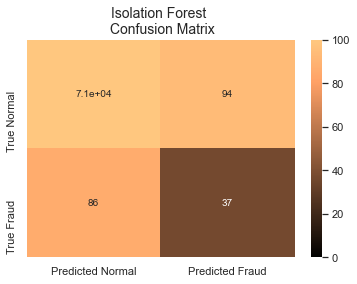

In [67]:
plot_conf_matrix('Isolation Forest', isof_predictions, y_test)

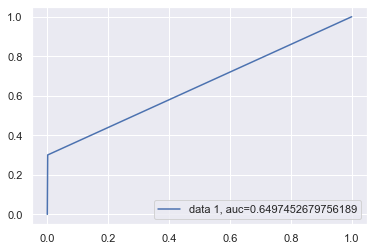

In [62]:
fpr, tpr, _ = metrics.roc_curve(y_test,  isof_predictions)
auc = metrics.roc_auc_score(y_test, isof_predictions)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Model Comparison

In [68]:
# Printing our Metric reports for our models
metric_report('Logistic Regression', y_test, lr_predictions)
metric_report('Support Vector Machine', y_test, svm_predictions)
metric_report('Isolation Forest', y_test, isof_predictions)

Logistic Regression Number of Errors: 71
Accuracy Score :
0.9990028369989608
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.73      0.67      0.70       123

    accuracy                           1.00     71202
   macro avg       0.86      0.84      0.85     71202
weighted avg       1.00      1.00      1.00     71202

Support Vector Machine Number of Errors: 70608
Accuracy Score :
0.008342462290385102
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.01      0.01     71079
           1       0.00      0.94      0.00       123

    accuracy                           0.01     71202
   macro avg       0.49      0.47      0.01     71202
weighted avg       0.98      0.01      0.01     71202

Isolation Forest Number of Errors: 180
Accuracy Score :
0.9974719811241257
Classification Report :
              precision    recall  f1

# Conclusions

It seems that there is a clear best and worst model here. The SVM model performed very poorly, perhaps due to too much noise in the data or maybe due to the extreme inbalance of the set. In its predictions, it has a high recall score because it has an extremely high false positive rate, as can be visualized in the confusion matrix above. 

The Isolation Forest model performed better, but not well. While the number of error was low (less than 1%), our model failed to predict many true negatives, and instead predicted a near equal amount of false positives and false negatives. This leads to low scores in nearly every metric.

The Logistic Regression model performed very well. It predicted 67% of our fraud cases, and mislabeled only 71 observations. With an F1 score of .7, it's safe to say that our logistic regression model is the one we would recommend. The great performance was likely aided by how clean our data set is. There was no missing data, and nearly all of the data has been normalized through PCA. This was also the least time intensive model. It took about 13 seconds to run this model, whereas the Isolation Forest took 20 seconds and the Support Vector Model took over 7 hours.

# Future Work

We believe that the performance of all three models can be improved. The largest improvement would come through feature selection using gridsearch or another method. We did not take that step in this analysis due to time constraints. With our SVM model already taking 7 hours to run, a gridsearch for feature selection would greatly increase our completion time. This could be addressed by alotting more time for completion or providing additional computing power.

Another performance boost could be attained by testing various boosting algorithms, such as adaboost or xgboosting. Our reason for not including this in our project today is the same as with gridsearch. With more time alotment or computing power, we would love to see how our models can be improved upon.